  Copyright(c) 2021 UNIADEX, Ltd. All Rights Reserved.  
  CONFIDENTIAL  
  Author: UNIADEX, Ltd.

# 分析
切り出したショットデータを取得し、分析します。  
以下は特定ショットのデータを取得/確認し、特徴点（荷重開始点/最大荷重点/破断点）を抽出、その後全ショットから特徴点を抽出するサンプルコードです。抽出した特徴点はElasticsearchに格納されます。

In [6]:
# ライブラリインポート
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../'))
from backend.cut_out_shot.cut_out_shot import CutOutShot
from backend.common import common
from backend.common.common_logger import logger
from backend.data_reader.data_reader import DataReader
from backend.analyzer.h_one_extract_features import *
from backend.analyzer.analyzer import Analyzer
from backend.utils.df_to_els import *

In [7]:
# ショットデータインデックス一覧
ElasticManager.show_indices(index="shots-*-data")

,index,docs.count,store.size
0,shots-20210101000000-data,2624,406
1,shots-20210709190000-data,4000000,457344
2,shots-machine-01-20210101000000-data,2624,403
3,shots-machine-01-20210327141514-data,115821,13701


In [21]:
# 対象データ設定
machine_id = "machine-01"
target_datetime = "20210327141514"
target = machine_id + "-" + target_datetime
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

# 1ショットで特徴点抽出

## ショット1番を取得して確認

In [9]:
dr = DataReader()

shot_number = 1
shot_df = dr.read_shot(shots_data_index, shot_number=shot_number)
shot_df.head()

,timestamp,sequential_number,sequential_number_by_shot,rawdata_sequential_number,stroke_displacement,shot_number,tags,load01,load02,load03,load04
0,2021-03-27T05:15:14.199280,0,0,19901,53.73375,1,[],-0.068,-0.033,-0.033,0.023
1,2021-03-27T05:15:14.199290,1,1,19902,53.73375,1,[],-0.049,-0.005,-0.056,0.018
2,2021-03-27T05:15:14.199300,2,2,19903,53.72500,1,[],-0.034,0.002,-0.071,0.001
3,2021-03-27T05:15:14.199310,3,3,19904,53.72500,1,[],-0.044,-0.005,-0.076,-0.006
4,2021-03-27T05:15:14.199320,4,4,19905,53.72500,1,[],-0.061,-0.016,-0.101,-0.011


In [10]:
# ショットメタデータを確認
shots_meta_df = dr.read_shots_meta(shots_meta_index)
shots_meta_df.head()

,timestamp,shot_number,spm,num_of_samples_in_cut_out
0,2021-03-27T05:15:14.209294,1,80.0,3855
1,2021-03-27T05:15:14.956057,2,80.0,3865
2,2021-03-27T05:15:15.702899,3,80.0,3867
3,2021-03-27T05:15:16.449913,4,80.0,3856
4,2021-03-27T05:15:17.196715,5,80.0,3864


In [11]:
# ショットの数を確認
print(f"ショット数：{len(shots_meta_df)}")

ショット数：30


In [12]:
# 80spmを超えるような不正なショットがないか確認
pd.set_option('display.max_rows', 3300)
shots_meta_df[shots_meta_df.spm > 80]

,timestamp,shot_number,spm,num_of_samples_in_cut_out


In [13]:
# spm
spm = float(shots_meta_df[shots_meta_df.shot_number == 1].spm)
print(f"spm：{spm}")

spm：80.0


## 特徴点抽出
1ショットから最大荷重点、荷重開始点、破断点を取得します。  

***shot_data***: 対象ショットデータ  
***spm***: spm  
***func***：適用するロジック  
***sub_func***：サブロジック  
***disp_chart***: グラフ表示

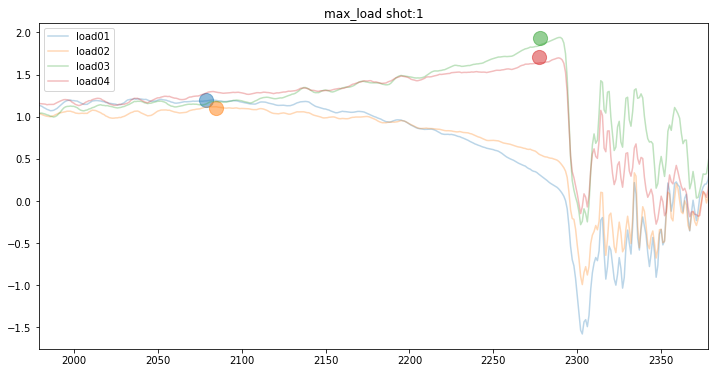

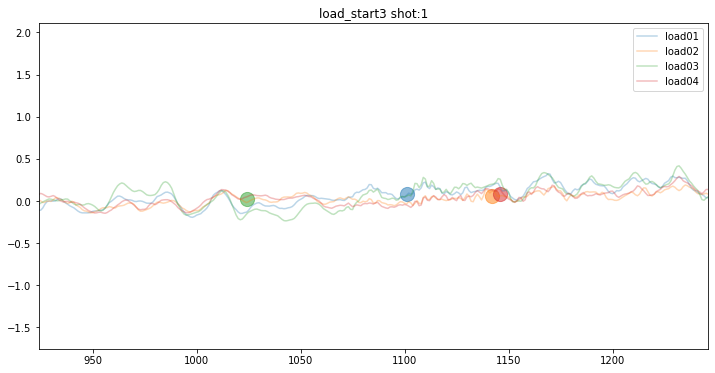

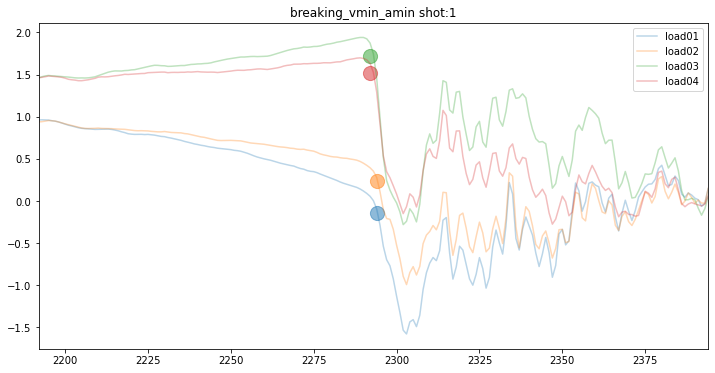

In [14]:
# 最初のショットの最大荷重点、荷重開始点、破断点を確認
max_load_indicies, max_load_values, debug_values = extract_features(shot_data=shot_df, spm=spm, func=max_load, shot=shot_number, disp_chart=True)
load_start_indicies, load_start_values, debug_values = extract_features(shot_df, spm, load_start3, shot=shot_number, disp_chart=True)
break_load_indicies, break_load_values, debug_values = extract_features(shot_df, spm, breaking_vmin_amin, sub_func=narrowing_v4min_mab, shot=shot_number, disp_chart=True)

In [15]:
# 各特徴点のインデックス番号と値を確認
print(f"【最大荷重点】\n indicies：{max_load_indicies}, values：{max_load_values}")
print(f"【荷重開始点】\n indicies：{load_start_indicies}, values：{load_start_values}")
print(f"【破断点】　　\n indicies：{break_load_indicies}, values：{break_load_values}")

【最大荷重点】
 indicies：[2079, 2085, 2278, 2277], values：[1.1981914891624956, 1.1009275528268812, 1.9346870955396511, 1.710061967263811]
【荷重開始点】
 indicies：[1101, 1142, 1024, 1146], values：[0.08214786967418547, 0.05578195488721805, 0.024112781954887218, 0.07723057644110276]
【破断点】　　
 indicies：[2294, 2294, 2292, 2292], values：[-0.1458068295728845, 0.2387910056581619, 1.7204688720138488, 1.5201684979699985]


# 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  

***target***: 対象ショットデータ（yyyyMMddHHMMSS）  
***shots_df***: ショットデータのDataFrame
***shots_meta_df***: ショットメタデータのDataFrame  
***feature***: 抽出する特徴点名（max/start/break）  
***func***：適用するロジック  
***sub_func***：サブロジック  
***exclude_shots***: 除外ショット(ex: exclude_shots=(1227, 1228, 1229))  

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [16]:
%%time
dr = DataReader()
shots_df = dr.multi_process_read_all(shots_data_index)

[2021/08/17 14:45:31.294] INFO - data_reader.py#multi_process_read_all:60: データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
[2021/08/17 14:45:31.299] INFO - elastic_manager.py#multi_process_range_scan:290: Data read start. data_count: 115821.
CPU times: user 475 ms, sys: 62.3 ms, total: 538 ms
Wall time: 2.68 s


In [17]:
len(shots_df)

115821

In [18]:
# ショットメタデータ読み込み
shots_meta_df = dr.read_shots_meta(shots_meta_index)

## 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  

***target***: 対象ショットデータ（yyyyMMddHHMMSS）  
***shots_df***: ショットデータ  
***shots_meta_df***: ショットメタデータ  
***feature***: 抽出する特徴点名（max/start/break）  
***func***：適用するロジック  
***sub_func***：サブロジック  
***exclude_shots***：除外するショット番号（例：exclude_shots=(1227, 1228, 1229)）

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [19]:
# 不正ショットの除外
exclude_shots=(983, 1227, 1228, 1229, 1369, 1381, 2894)

In [22]:
analyzer = Analyzer(target, shots_df, shots_meta_df, exclude_shots)

In [23]:
# 最大荷重点
analyzer.apply(
    feature="max",
    func=max_load,
    sub_func=None,
)

[2021/08/17 14:47:03.968] INFO - analyzer.py#apply:45: apply start.
[2021/08/17 14:47:04.139] INFO - elastic_manager.py#delete_exists_index:164: delete index 'shots-machine-01-20210327141514-max-point' finished. result: {'acknowledged': True}
[2021/08/17 14:47:05.137] INFO - analyzer.py#apply:57: apply finished.


In [24]:
dr = DataReader()
max_index = "shots-" + target + "-max-point"
max_df = dr.read_all(max_index)
max_df

[2021/08/17 14:47:07.672] INFO - data_reader.py#read_all:102: データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
[2021/08/17 14:47:07.678] INFO - data_reader.py#read_all:106: データ件数: 120
[2021/08/17 14:47:07.684] INFO - data_reader.py#read_all:116: Data reading has finished.


,timestamp,shot_number,load,sequential_number,sequential_number_by_shot,value
0,2021-03-27T05:15:14.220098,1,load01,2079,2079,1.198191
1,2021-03-27T05:15:14.220159,1,load02,2085,2085,1.100928
2,2021-03-27T05:15:14.222081,1,load04,2277,2277,1.710062
3,2021-03-27T05:15:14.222091,1,load03,2278,2278,1.934687
4,2021-03-27T05:15:14.966641,2,load01,5912,2057,1.212105
5,2021-03-27T05:15:14.966641,2,load02,5912,2057,1.044028
6,2021-03-27T05:15:14.968644,2,load04,6112,2257,1.828050
7,2021-03-27T05:15:14.968654,2,load03,6113,2258,2.151081
8,2021-03-27T05:15:15.713884,3,load01,9817,2097,1.166090
9,2021-03-27T05:15:15.713954,3,load02,9824,2104,1.087371


In [25]:
# 荷重開始点
analyzer.apply(
    feature="start",
    func=load_start3,
    sub_func=None,
)

[2021/08/17 14:47:12.555] INFO - analyzer.py#apply:45: apply start.
[2021/08/17 14:47:12.699] INFO - elastic_manager.py#delete_exists_index:164: delete index 'shots-machine-01-20210327141514-start-point' finished. result: {'acknowledged': True}
[2021/08/17 14:47:14.112] INFO - analyzer.py#apply:57: apply finished.


In [26]:
dr = DataReader()
start_index = "shots-" + target + "-start-point"
start_df = dr.read_all(start_index)
start_df

[2021/08/17 14:47:16.400] INFO - data_reader.py#read_all:102: データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
[2021/08/17 14:47:16.408] INFO - data_reader.py#read_all:106: データ件数: 120
[2021/08/17 14:47:16.431] INFO - data_reader.py#read_all:116: Data reading has finished.


,timestamp,shot_number,load,sequential_number,sequential_number_by_shot,value
0,2021-03-27T05:15:14.209534,1,load03,1024,1024,0.024113
1,2021-03-27T05:15:14.210305,1,load01,1101,1101,0.082148
2,2021-03-27T05:15:14.210716,1,load02,1142,1142,0.055782
3,2021-03-27T05:15:14.210756,1,load04,1146,1146,0.077231
4,2021-03-27T05:15:14.956247,2,load01,4874,1019,0.029499
5,2021-03-27T05:15:14.956257,2,load03,4875,1020,0.019040
6,2021-03-27T05:15:14.957649,2,load02,5014,1159,0.056263
7,2021-03-27T05:15:14.957649,2,load04,5014,1159,0.076183
8,2021-03-27T05:15:15.701968,3,load03,8627,907,-0.039281
9,2021-03-27T05:15:15.704081,3,load01,8838,1118,0.081223


In [27]:
# 破断点
analyzer.apply(
    feature="break",
    func=breaking_vmin_amin,
    sub_func=narrowing_v4min_mab,
)

[2021/08/17 14:47:21.995] INFO - analyzer.py#apply:45: apply start.
[2021/08/17 14:47:22.132] INFO - elastic_manager.py#delete_exists_index:164: delete index 'shots-machine-01-20210327141514-break-point' finished. result: {'acknowledged': True}
[2021/08/17 14:47:23.318] INFO - analyzer.py#apply:57: apply finished.


In [30]:
dr = DataReader()
break_index = "shots-" + target + "-break-point"
break_df = dr.read_all(break_index)
break_df

[2021/08/17 14:47:45.605] INFO - data_reader.py#read_all:102: データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
[2021/08/17 14:47:45.609] INFO - data_reader.py#read_all:106: データ件数: 120
[2021/08/17 14:47:45.616] INFO - data_reader.py#read_all:116: Data reading has finished.


,timestamp,shot_number,load,sequential_number,sequential_number_by_shot,value,break_channels
0,2021-03-27T05:15:14.222231,1,load03,2292,2292,1.720469,"[load01, load02]"
1,2021-03-27T05:15:14.222231,1,load04,2292,2292,1.520168,"[load01, load02]"
2,2021-03-27T05:15:14.222251,1,load01,2294,2294,-0.145807,"[load01, load02]"
3,2021-03-27T05:15:14.222251,1,load02,2294,2294,0.238791,"[load01, load02]"
4,2021-03-27T05:15:14.968784,2,load03,6126,2271,2.057653,"[load01, load02]"
5,2021-03-27T05:15:14.968784,2,load04,6126,2271,1.710159,"[load01, load02]"
6,2021-03-27T05:15:14.968814,2,load01,6129,2274,-0.378801,"[load01, load02]"
7,2021-03-27T05:15:14.968814,2,load02,6129,2274,0.075030,"[load01, load02]"
8,2021-03-27T05:15:15.716057,3,load03,10034,2314,1.125854,"[load01, load02]"
9,2021-03-27T05:15:15.716057,3,load04,10034,2314,1.086519,"[load01, load02]"
